# Fitting Scaling Relationships with ScaleRPy

Created by Bryanne McDonough 12/3/24

In [10]:
import ScaleRPy as sr
from ScaleRPy.fitting import fit_funcs as fit
from ScaleRPy.man_dat import *
import numpy as np
import matplotlib.pyplot as plt


In [9]:
help(sr)

Help on package ScaleRPy:

NAME
    ScaleRPy

PACKAGE CONTENTS
    man_dat

SUBMODULES
    fitting

FILE
    c:\users\br.mcdonough\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local-packages\python312\site-packages\scalerpy\__init__.py




In [3]:
spax = np.load('C:/Users/br.mcdonough/Documents/Projects/ScaleRPy/flatstack.npy')
print(spax.shape)
print(max(spax[3,:]))

(5, 12815387)
3.0


In [12]:
#Create a SpatGalDat object with your spatially-resolved data
ind = spax[3,:]
wh=np.nonzero((ind!=0))
##replace with actual data call for self, for package help doc replace with generic
mass = spax[0,:][wh]
sfr = spax[1,:][wh]
gas = []
sfr[-1] = np.nan
dat = SpatGalDat(s_mass = mass, sfr = sfr, scale = 'log')
print(dat.sfr)


[-2.39342146 -2.18347182 -2.94251529 ... -2.05674678 -5.2663414
         nan]


In [24]:
#Identify the default units:
print(dat.s_mass_unit)
print(dat.sfr_unit)
#print(dat.gas_unit)

$M_\odot \mathrm{kpc}^{-2}$
$M_\odot \mathrm{yr}^{-1} \mathrm{kpc}^{-2}$


The default units are in written in latex because they will make up the axis of our formal plots. You can update the units manually.

In [25]:
dat.s_mass_unit = r'$M_\odot \mathrm{kpc}^{-2}$'
print(dat.s_mass_unit)

$M_\odot \mathrm{kpc}^{-2}$


[[ 6.03846154  6.11538462  6.19230769  6.26923077  6.34615385  6.42307692
   6.5         6.57692308  6.65384615  6.73076923  6.80769231  6.88461538
   6.96153846  7.03846154  7.11538462  7.19230769  7.26923077  7.34615385
   7.42307692  7.5         7.57692308  7.65384615  7.73076923  7.80769231
   7.88461538  7.96153846  8.03846154  8.11538462  8.19230769  8.26923077
   8.34615385  8.42307692  8.5         8.57692308  8.65384615  8.73076923
   8.80769231  8.88461538  8.96153846]
 [-2.81080069 -2.76125874 -2.69748494 -2.61125359 -2.5615512  -2.47627228
  -2.4279472  -2.39662004 -2.33511723 -2.24150277 -2.18951427 -2.13005738
  -2.04134036 -1.98310979 -1.92789135 -1.84652012 -1.77280167 -1.67384567
  -1.61906892 -1.53992523 -1.46736182 -1.411111   -1.34606506 -1.2629761
  -1.22704342 -1.20762477 -1.19823176 -1.16449387 -1.17525556 -1.17386168
  -1.15905374 -1.17395224 -1.12654205 -1.15579034 -1.11539129 -1.07307963
  -1.06187604 -1.01080855 -0.975234  ]
 [ 0.12145786  0.11651341  0.113273

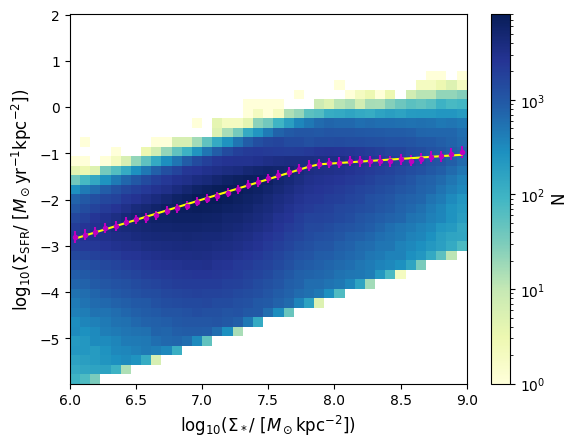

In [13]:
dat.SFMS_ridge(xrange=(6,9),fittype='kde')
#how do results depend on number of bins?



print(dat.SFMS_ridgept)
print(dat.SFMS_params)
print(dat.SFMS_paramerr)

[144.0 220.0 263.0 360.0 350.0 469.0 507.0 666.0 769.0 916.0 1210.0 1457.0
 1848.0 2498.0 3441.0 3866.0 3455.0 2683.0 1826.0 1357.0 530.0 80.0 7.0
 1.0 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[[ 6.06186407e+00  6.18558841e+00  6.30931275e+00  6.43303709e+00
   6.55676143e+00  6.68048577e+00  6.80421011e+00  6.92793445e+00
   7.05165879e+00  7.17538313e+00  7.29910747e+00  7.42283181e+00
   7.54655615e+00  7.67028049e+00  7.79400483e+00  7.91772917e+00
   8.04145351e+00  8.16517785e+00  8.28890219e+00  8.41262653e+00
   8.53635087e+00  8.66007521e+00  8.78379955e+00  8.90752389e+00
   9.03124823e+00  9.15497257e+00  9.27869691e+00  9.40242125e+00
   9.52614559e+00  9.64986993e+00  9.77359427e+00  9.89731861e+00
   1.00210429e+01  1.01447673e+01  1.02684916e+01  1.03922160e+01
   1.05159403e+01  1.06396646e+01  1.07633890e+01]
 [-2.79163096e+00 -2.69424021e+00 -2.57158525e+00 -2.45216284e+00
  -2.40841597e+00 -2.29705564e+00 -2.19040460e+00 -2.07465942e+00
  -1.97018

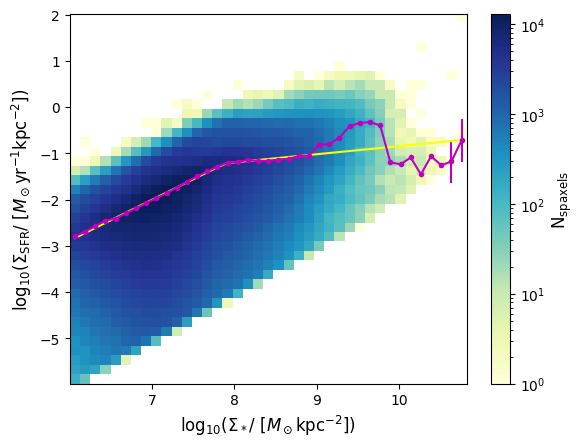

In [29]:
dat.SFMS_ridge(fittype='kde')#, xrange=(6,9.5))
#how do results depend on number of bins?



print(dat.SFMS_ridgept)
print(dat.SFMS_params)
print(dat.SFMS_paramerr)

(array([    142,     155,     613, ..., 1418373, 1418379, 1418387]),)


"\ny_c = (yedges[:-1] + yedges[1:]) / 2\nprint(len(y_c), len(histval[0,:]))\nskew_fit, skewerr = fit.fit_gauss(y_c, histval[0,:])#, priors = (-2,0.8,1))\nprint(skew_fit)\n\ncol=histval[0,:]\nwh = np.isfinite(col)\ncol=col[wh][12:18]\ny_c = y_c[wh][12:18]\nplt.plot(y_c, fit.gauss(y_c,*skew_fit))\n#plt.plot(y_c, fit.skew_normal_pdf(y_c,-2.8,0.5,-1))\nprint(col/simpson(col, x= y_c))\nplt.plot(y_c,col/simpson(col, x= y_c), marker='.')\n#from scipy.integrate import simpson\n#print(simpson(fit.skew_normal_pdf(y_c,-2.8,0.5,-1),x=y_c))\n"

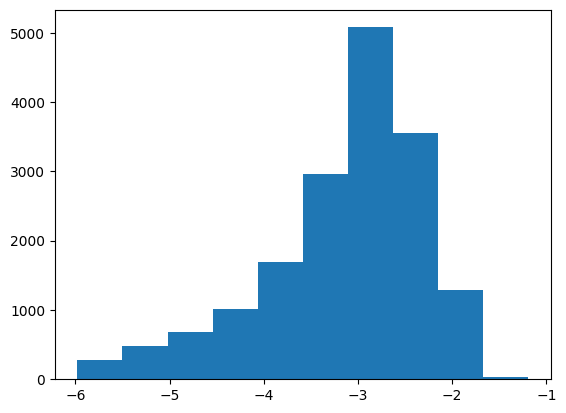

In [14]:
#histval = dat.SFMS_histval
#print(histval[-1,:])
xedges = dat.SFMS_xedges
yedges = dat.SFMS_yedges
bin=0

whbin = np.nonzero((mass>xedges[bin]) & (mass<= xedges[bin+1]) & (np.isfinite(sfr)))
plt.hist(sfr[whbin])
print(whbin)

"""
y_c = (yedges[:-1] + yedges[1:]) / 2
print(len(y_c), len(histval[0,:]))
skew_fit, skewerr = fit.fit_gauss(y_c, histval[0,:])#, priors = (-2,0.8,1))
print(skew_fit)

col=histval[0,:]
wh = np.isfinite(col)
col=col[wh][12:18]
y_c = y_c[wh][12:18]
plt.plot(y_c, fit.gauss(y_c,*skew_fit))
#plt.plot(y_c, fit.skew_normal_pdf(y_c,-2.8,0.5,-1))
print(col/simpson(col, x= y_c))
plt.plot(y_c,col/simpson(col, x= y_c), marker='.')
#from scipy.integrate import simpson
#print(simpson(fit.skew_normal_pdf(y_c,-2.8,0.5,-1),x=y_c))
"""


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  74. 150. 145. 194. 216. 237. 332. 384. 503. 645. 745. 665. 580. 462.
 207.  87.  28.   2.   1.  nan  nan  nan  nan  nan  nan]
39 39
[-2.2049869   1.1123986  -3.05597574]
[0.06414145 0.13001645 0.12568256 0.1681546  0.18722368 0.20542598
 0.28776973 0.3328421  0.43598848 0.55907071 0.64574834 0.57640624
 0.50273025 0.40045065 0.17942269 0.07540954 0.02426974 0.00173355
 0.00086678]


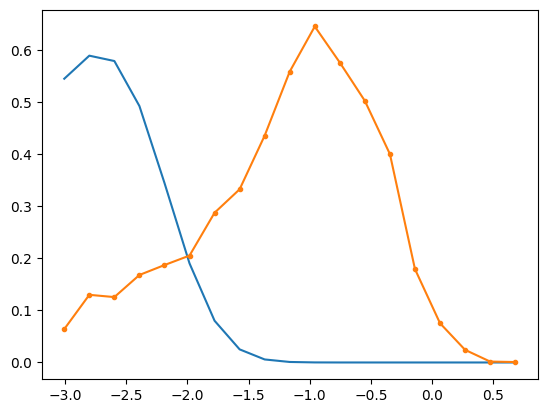

In [141]:
histval = dat.SFMS_histval
print(histval[-1,:])
yedges = dat.SFMS_yedges
y_c = (yedges[:-1] + yedges[1:]) / 2
print(len(y_c), len(histval[0,:]))
skew_fit, skewerr = fit.fit_skew_norm(y_c, histval[0,:])#, priors = (-2,0.8,1))
print(skew_fit)

col=histval[-1,:]
wh = np.isfinite(col)
col=col[wh]
y_c = y_c[wh]
plt.plot(y_c, fit.skew_normal_pdf(y_c,*skew_fit))
#plt.plot(y_c, fit.skew_normal_pdf(y_c,-2.8,0.5,-1))
print(col/simpson(col, x= y_c))
plt.plot(y_c,col/simpson(col, x= y_c), marker='.')
#from scipy.integrate import simpson
#print(simpson(fit.skew_normal_pdf(y_c,-2.8,0.5,-1),x=y_c))



[0.06776763 0.4655752  0.06274063 0.19150707]


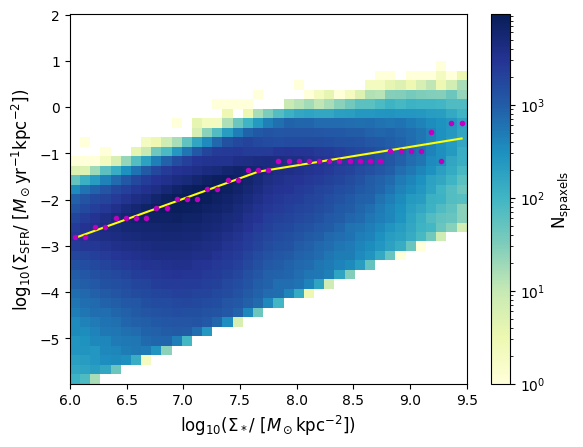

In [142]:
hist, ax, ridge = dat.SFMS_ridge(xrange=(6,9.5))
#how do results depend on number of bins?

print(ridge)

#In this case, a smaller xrange will fix the overfitting of points based on less data
#But ideally would have errors on the ridge points
#instead of fitting with Gaussian, skew-normal?

[0.06776763 0.4655752  0.06274063 0.19150707]


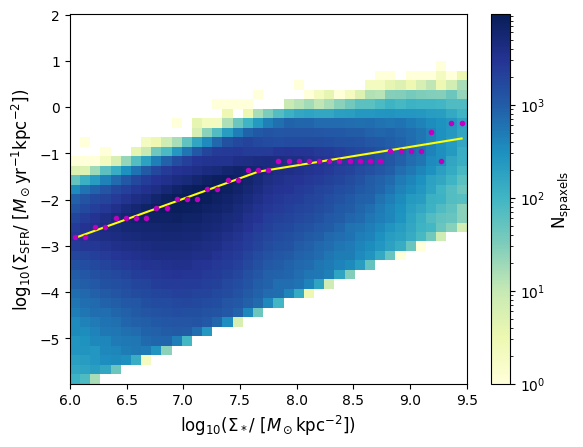

In [143]:
hist, ax, ridge = dat.SFMS_ridge(xrange=(6,9.5))
#how do results depend on number of bins?
#overwriting SFMS_ridge function
print(ridge)
#left off editing this function to also plot the ridge line
#may want to update the functions used by curvefit to take in one array with the params? 

Next steps: find way to handle quenched spaxels (prefer removing quenched as opposed)
AND have choice to fit histogram columns with a double gaussian

In R&P, highlight MS ridge by multiplying counts by SFR